In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PyAstronomy import pyasl
from datetime import datetime
from datetime import timedelta, date
from astropy.timeseries import LombScargle
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

from NEID_solar_functions import *
from GP_kernels import *

In [3]:
v_grid  = np.loadtxt('./data_v4/v_grid.txt')
CCF     = np.loadtxt('./data_v4/CCF.txt')
σCCF   = np.loadtxt('./data_v4/σCCF.txt')
bjd     = np.loadtxt('./data_v4/bjd.txt')
rv      = np.loadtxt('./data_v4/rv.txt')
σrv     = np.loadtxt('./data_v4/σrv.txt')
idx_rej = np.array(np.loadtxt('idx_rej'), dtype=bool)

# RV data

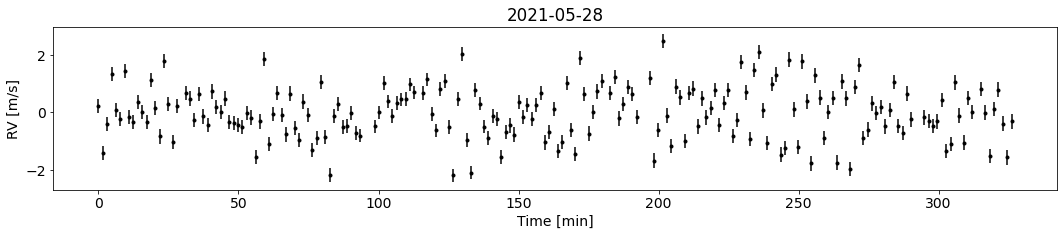

In [92]:
date = datetime(2021, 5, 28)
T1 = pyasl.jdcnv(date)
idx_bjd = (bjd>T1) & (bjd<T1+1) & (~idx_rej)

t = (bjd[idx_bjd]-min(bjd[idx_bjd]))*24*60
y = rv[idx_bjd] - np.mean(rv[idx_bjd])
reg = LinearRegression().fit(t.reshape((-1, 1)), y)
y = y - reg.predict(t.reshape((-1, 1)))
yerr = σrv[idx_bjd]

plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(18, 3))
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.title(str(date)[:10])
plt.xlabel("Time [min]")
plt.ylabel("RV [m/s]")
plt.show()

# GP model

In [93]:
# Oscillation
w0 = 2*np.pi/5.2
Q = 6
S0 = np.var(y) / (w0 * Q)

# Granulation
nu_max = 3090 #μHz
omega_1 = 2*np.pi*0.317*nu_max**0.97
omega_2 = 2*np.pi*0.948*nu_max**0.992
a_n = 3382*nu_max**(-0.609)/100
S1 = a_n**2*np.sqrt(2)/omega_1
S2 = a_n**2*np.sqrt(2)/omega_2
Q = 1/np.sqrt(2)
omega_1 *= 60e-6 # convert to 1/min
omega_2 *= 60e-6 # convert to 1/min


def GP_granulation_fit(t, y, yerr):

    bounds = dict(log_S0=(-15, 15), log_omega0=(-3, 0.5))
    k1 = terms.SHOTerm(log_S0=np.log(S1), log_Q=np.log(Q), log_omega0=np.log(omega_1), bounds=bounds)
    k1.freeze_parameter("log_Q")
    # k1.freeze_parameter("log_S0")
    bounds = dict(log_S0=(-15, 15), log_omega0=(-1.5, 1.5))
    k2 = terms.SHOTerm(log_S0=np.log(S2), log_Q=np.log(Q), log_omega0=np.log(omega_2), bounds=bounds)
    k2.freeze_parameter("log_Q")
    # k2.freeze_parameter("log_S0")
    kernel = k1 + k2
    # kernel = k2

    gp = celerite.GP(kernel, mean=np.mean(y))
    gp.compute(t, yerr)  # You always need to call compute once.

    initial_params = gp.get_parameter_vector()
    bounds = gp.get_parameter_bounds()

    r = minimize(neg_log_like, initial_params, method="L-BFGS-B", bounds=bounds, args=(y, gp))
    gp.set_parameter_vector(r.x)
    
    return gp


def GP_osil_gran_fit(t, y, yerr):

    bounds = dict(log_S0=(-15, 15), log_omega0=(-3, 0.5))
    k1 = terms.SHOTerm(log_S0=np.log(S1*10), log_Q=np.log(Q), log_omega0=np.log(omega_1), bounds=bounds)
    k1.freeze_parameter("log_Q")
    
    bounds = dict(log_S0=(-15, 15), log_omega0=(-1.5, 1.5))
    k2 = terms.SHOTerm(log_S0=np.log(S2*10), log_Q=np.log(Q), log_omega0=np.log(omega_2), bounds=bounds)
    k2.freeze_parameter("log_Q")
    
    bounds = dict(log_S0=(-15, 15), log_Q=(-15, 15), log_omega0=(np.log(2*np.pi/6), np.log(2*np.pi/4)))
    k3 = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(10), log_omega0=np.log(w0), bounds=bounds)

    kernel = k1 + k2 + k3

    gp = celerite.GP(kernel, mean=np.mean(y))
    gp.compute(t, yerr)  # You always need to call compute once.

    initial_params = gp.get_parameter_vector()
    bounds = gp.get_parameter_bounds()

    r = minimize(neg_log_like, initial_params, method="L-BFGS-B", bounds=bounds, args=(y, gp))
    gp.set_parameter_vector(r.x)
    
    return gp

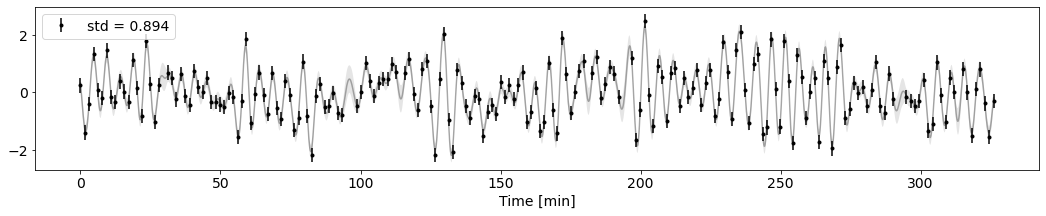

Final log-likelihood:  -196.33685312948467


S1 = 1.877560416870317e-05 
S2 = 5.260969198478516e-06
s[0]:log_S0 	: 0.7885263933756806
s[0]:log_omega0 	: 0.11703354617584515
s[1]:log_S0 	: 0.00021610305185564428
s[1]:log_omega0 	: 0.3663115081563763
s[2]:log_S0 	: 0.0773905142626533
s[2]:log_Q 	: 7.154121555209533
s[2]:log_omega0 	: 1.197655976086368


s[0]:log_S0 	: 7.9682625210315114
s[0]:log_omega0 	: 53.68704540268292
s[1]:log_S0 	: 29074.949442994082
s[1]:log_omega0 	: 17.152574154174076
s[2]:log_S0 	: 81.18805472535402
s[2]:log_Q 	: 0.8782609099791234
s[2]:log_omega0 	: 5.246235507220881


In [94]:
fig = plt.figure(figsize=(18, 3))
gp_fit = GP_osil_gran_fit(t, y, yerr)
# gp_fit = GP_granulation_fit(t, y, yerr) 
# gp_fit = GP_fit_p1(t, y, yerr, p=10)
# gp_fit = GP_fit_Matern52Kernel(t, yerr, r=3)
# gp_fit = GP(t, y, yerr)
x = np.linspace(min(t), max(t), 10*len(t))
pred_mean, pred_var = gp_fit.predict(y, x, return_var=True)
pred_std = np.sqrt(pred_var)        
plt.plot(x, pred_mean, color='k', alpha=0.3)
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color='k', alpha=0.1,
                 edgecolor="none")
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0, label='std = {:.3f}'.format(np.std(y)))
plt.xlabel("Time [min]")
plt.legend(loc=2)
plt.show()

print('Final log-likelihood:  {0}'.format(gp_fit.log_likelihood(y)))
print('\n')    

print('S1 =', S1, '\nS2 =', S2)
for key, value in gp_fit.get_parameter_dict().items():
    print(key[11:], '\t:', np.exp(value))
print('\n')
    
for key, value in gp_fit.get_parameter_dict().items():
    print(key[11:], '\t:', 2*np.pi/np.exp(value))    
    

In [95]:
2*np.pi/1.18722407201767, 2*np.pi/0.29026390041496786, 2*np.pi/1.038305093734209

(5.292333145251514, 21.646457923968505, 6.051386384499419)

### Oscillation part

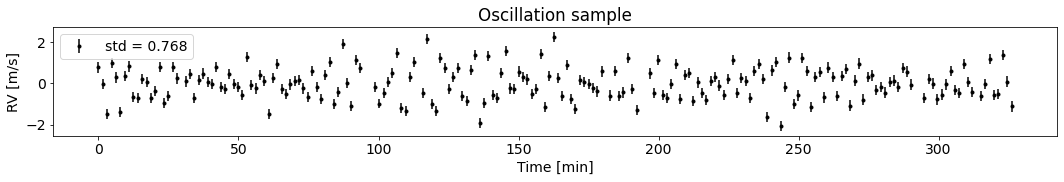

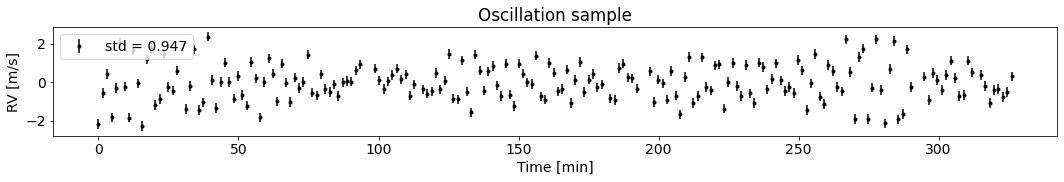

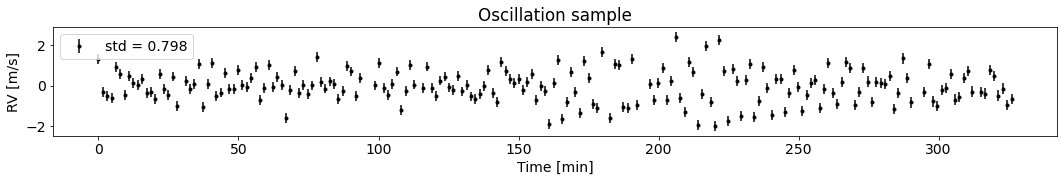

In [96]:
kernel = terms.SHOTerm(log_S0 = gp_fit.get_parameter('kernel:terms[2]:log_S0'), 
                       log_Q = gp_fit.get_parameter('kernel:terms[2]:log_Q'), 
                       log_omega0 = gp_fit.get_parameter('kernel:terms[2]:log_omega0'))
gp_data = celerite.GP(kernel)
gp_data.compute(t, yerr)

for i in range(3):
    y = gp_data.sample()
    fig = plt.figure(figsize=(18, 2))
    plt.title('Oscillation sample')
    plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0, label='std = {:.3f}'.format(np.std(y)))
    plt.xlabel("Time [min]")
    plt.ylabel("RV [m/s]")
    plt.legend(loc=2)
    plt.show()

### Granulation part

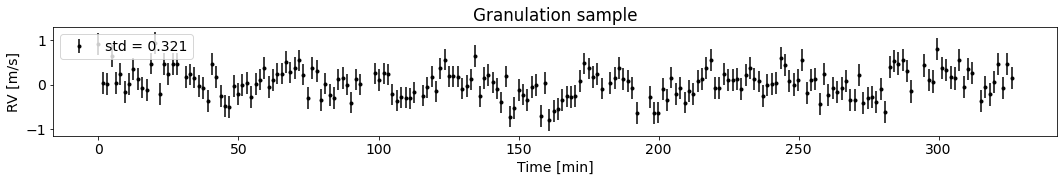

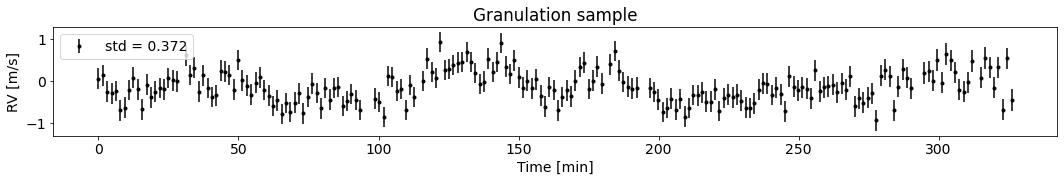

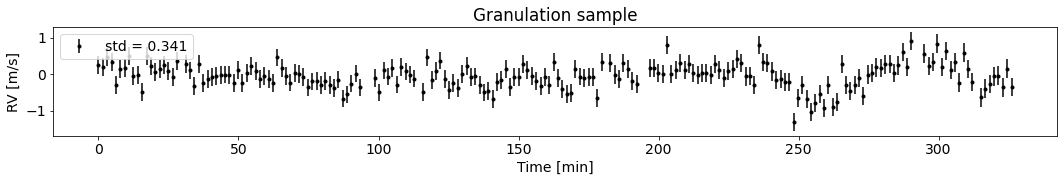

In [97]:
k1 = terms.SHOTerm(log_S0=gp_fit.get_parameter('kernel:terms[0]:log_S0'), log_Q=np.log(Q), log_omega0=gp_fit.get_parameter('kernel:terms[0]:log_omega0'))
k2 = terms.SHOTerm(log_S0=gp_fit.get_parameter('kernel:terms[1]:log_S0'), log_Q=np.log(Q), log_omega0=gp_fit.get_parameter('kernel:terms[0]:log_omega0'))
kernel = k1 + k2
gp_data = celerite.GP(kernel)
gp_data.compute(t, yerr)

for i in range(3):
    y = gp_data.sample()
    fig = plt.figure(figsize=(18, 2))
    plt.title('Granulation sample')
    plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0, label='std = {:.3f}'.format(np.std(y)))
    plt.xlabel("Time [min]")
    plt.ylabel("RV [m/s]")
    plt.legend(loc=2)
    plt.show()

# Mock data

### granulation

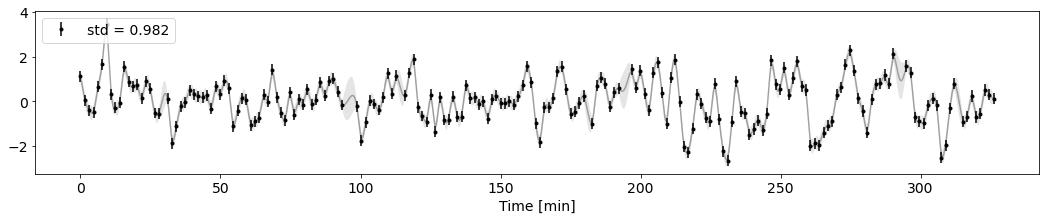

1.877560416870317e-05 5.260969198478516e-06
s[0]:log_S0 	: 1.484049629100457
s[0]:log_omega0 	: 0.8613483330800952
s[1]:log_S0 	: 5.0604208825886235e-05
s[1]:log_omega0 	: 2.860214828378209


In [89]:
nu_max = 3090 #μHz
omega_1 = 2*np.pi*0.317*nu_max**0.97
omega_2 = 2*np.pi*0.948*nu_max**0.992
a_n = 3382*nu_max**(-0.609)/100
S1 = a_n**2*np.sqrt(2)/omega_1
S2 = a_n**2*np.sqrt(2)/omega_2
Q = 1/np.sqrt(2)
omega_1 *= 60e-6 # convert to 1/min
omega_2 *= 60e-6 # convert to 1/min

k1 = terms.SHOTerm(log_S0=S1, log_Q=np.log(Q), log_omega0=np.log(omega_1))
k2 = terms.SHOTerm(log_S0=S2, log_Q=np.log(Q), log_omega0=np.log(omega_2))
kernel = k1 + k2
gp_data = celerite.GP(kernel)
gp_data.compute(t, yerr)
y = gp_data.sample()

fig = plt.figure(figsize=(18, 3))
# gp_fit = GP_osil_gran_fit(t, y, yerr)
gp_fit = GP_granulation_fit(t, y, yerr) 
x = np.linspace(min(t), max(t), 10*len(t))
pred_mean, pred_var = gp_fit.predict(y, x, return_var=True)
pred_std = np.sqrt(pred_var)        
plt.plot(x, pred_mean, color='k', alpha=0.3)
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color='k', alpha=0.1,
                 edgecolor="none")
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0, label='std = {:.3f}'.format(np.std(y)))
plt.xlabel("Time [min]")
plt.legend(loc=2)
plt.show()

print(S1, S2)
for key, value in gp_fit.get_parameter_dict().items():
    print(key[11:], '\t:', np.exp(value))

### Oscillation

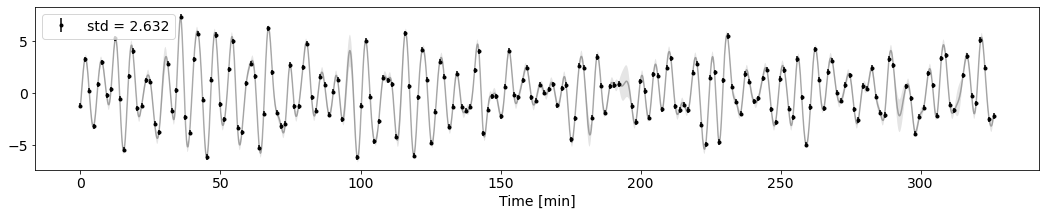

In [88]:
S0 = 0.12
Q = 5

k1 = terms.SHOTerm(log_S0=S1, log_Q=np.log(Q), log_omega0=np.log(2*np.pi/6))
kernel = k1 + k2
gp_data = celerite.GP(kernel)
gp_data.compute(t, yerr)
y = gp_data.sample()

fig = plt.figure(figsize=(18, 3))
gp_fit = GP(t, y, yerr)
# gp_fit = GP_granulation_fit(t, y, yerr) 
x = np.linspace(min(t), max(t), 10*len(t))
pred_mean, pred_var = gp_fit.predict(y, x, return_var=True)
pred_std = np.sqrt(pred_var)        
plt.plot(x, pred_mean, color='k', alpha=0.3)
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color='k', alpha=0.1,
                 edgecolor="none")
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0, label='std = {:.3f}'.format(np.std(y)))
plt.xlabel("Time [min]")
plt.legend(loc=2)
plt.show()